In [29]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.metrics import plot_confusion_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pump-it-up-competetion/test data.csv
/kaggle/input/pump-it-up-competetion/train labels.csv
/kaggle/input/pump-it-up-competetion/train data.csv


In [30]:
features = pd.read_csv(filepath_or_buffer='../input/pump-it-up-competetion/train data.csv', index_col='id')
targets = pd.read_csv(filepath_or_buffer='../input/pump-it-up-competetion/train labels.csv', index_col='id'
                     )
df = features.join(targets, how='left')
X = df.drop('status_group', axis=1)
y = df['status_group']

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_validate, y_train, y_validate = train_test_split(X, y, random_state = 42)

In [32]:
from sklearn.preprocessing import FunctionTransformer

def convert_categorical_to_string(data):
    return pd.DataFrame(data).astype(str)

CategoricalTypeConverter = FunctionTransformer(
    convert_categorical_to_string
)

In [33]:
drop_cols = []

In [34]:
def classify_columns(df, drop_cols):
    cols = df.columns
    keep_cols = [col for col in cols if col not in drop_cols]
    cat_cols = []
    num_cols = []
    for col in keep_cols:
        if df[col].dtype == object:
            cat_cols.append(col)
        else:
            num_cols.append(col)
    return cat_cols, num_cols

In [35]:
cat_cols, num_cols = classify_columns(X_train, drop_cols)

In [36]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder 

categorical_pipeline = Pipeline(
    steps=[
        (
            'typeConverter', 
            CategoricalTypeConverter
        ),
        (
            'imputer', 
            SimpleImputer(
                strategy='constant', 
                fill_value='missing'
            )
        ),
        (
            'standardizer', 
            OneHotEncoder(
                handle_unknown='ignore',
                dtype=float
            )
        )
    ]
)

In [37]:
from sklearn.preprocessing import StandardScaler

numerical_pipeline = Pipeline(
    steps=[
        (
            'imputer', 
            SimpleImputer(
                strategy='median'
            )
        ),
        (
            'standardizer', 
            StandardScaler()
        )
    ]
)

In [38]:
from sklearn.compose import ColumnTransformer

if len(drop_cols) > 0:
    preprocessor = ColumnTransformer(
        transformers=[
            (
                'numericalPreprocessor', 
                numerical_pipeline, 
                num_cols
            ),
            (
                'categoricalPreprocessor', 
                categorical_pipeline, 
                cat_cols
            ),
            (
                'dropPreprocessor', 
                'drop', 
                drop_cols
            )
        ]
    )
else:
    preprocessor = ColumnTransformer(
        transformers=[
            (
                'numericalPreprocessor', 
                numerical_pipeline, 
                num_cols
            ),
            (
                'categoricalPreprocessor', 
                categorical_pipeline, 
                cat_cols
            )
        ]
    )

In [39]:
from sklearn.ensemble import RandomForestClassifier

model1 = make_pipeline(preprocessor, RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42))
model1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numericalPreprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardizer',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'region_code',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('categoricalPreprocessor',
                

In [40]:
from xgboost import XGBClassifier

model2 = make_pipeline(preprocessor, XGBClassifier())
model2

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numericalPreprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardizer',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'region_code',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('categoricalPreprocessor',
                

In [41]:
from lightgbm import LGBMClassifier

model3 = make_pipeline(preprocessor, LGBMClassifier())
model3

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numericalPreprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardizer',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'region_code',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('categoricalPreprocessor',
                

In [42]:
model1.fit(X_train, y_train)
score = model1.score(X_validate, y_validate)
print(score)

0.794006734006734


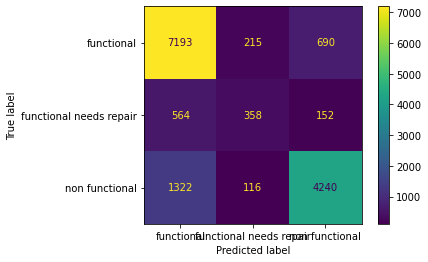

In [43]:
plot_confusion_matrix(model1, X_validate, y_validate) 

In [44]:
model2.fit(X_train, y_train)
score = model2.score(X_validate, y_validate)
print(score)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7901683501683502


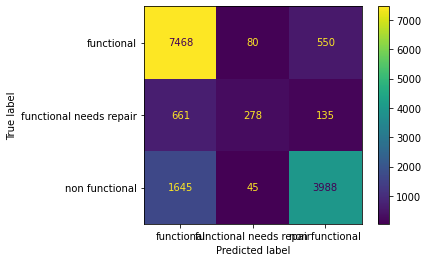

In [45]:
plot_confusion_matrix(model2, X_validate, y_validate) 

In [46]:
model3.fit(X_train, y_train)
score = model3.score(X_validate, y_validate)
print(score)

0.7905723905723906


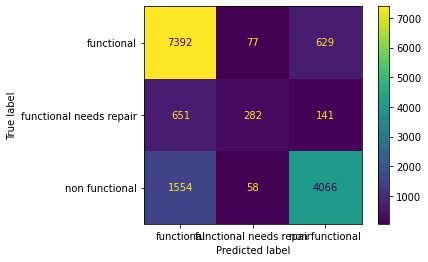

In [47]:
plot_confusion_matrix(model3, X_validate, y_validate) 

In [48]:
X_test = pd.read_csv(
    '../input/pump-it-up-competetion/test data.csv',
    index_col='id'
)
y_test = model1.predict(
    X_test
)
y_test2 = model2.predict(
    X_test
)
y_test3 = model3.predict(
    X_test
)

In [49]:
final_pred = np.array([])
for i in range(0,len(X_test)):
    if y_test2[i]==y_test3[i]:
        final_pred = np.append(final_pred,y_test2[i])
    else:
        final_pred = np.append(final_pred,y_test[i])

In [50]:
df_predictions = pd.DataFrame(
    final_pred, 
    index=X_test.index, 
    columns=['status_group']
)
df_predictions.to_csv(
    'Submission.csv'
)